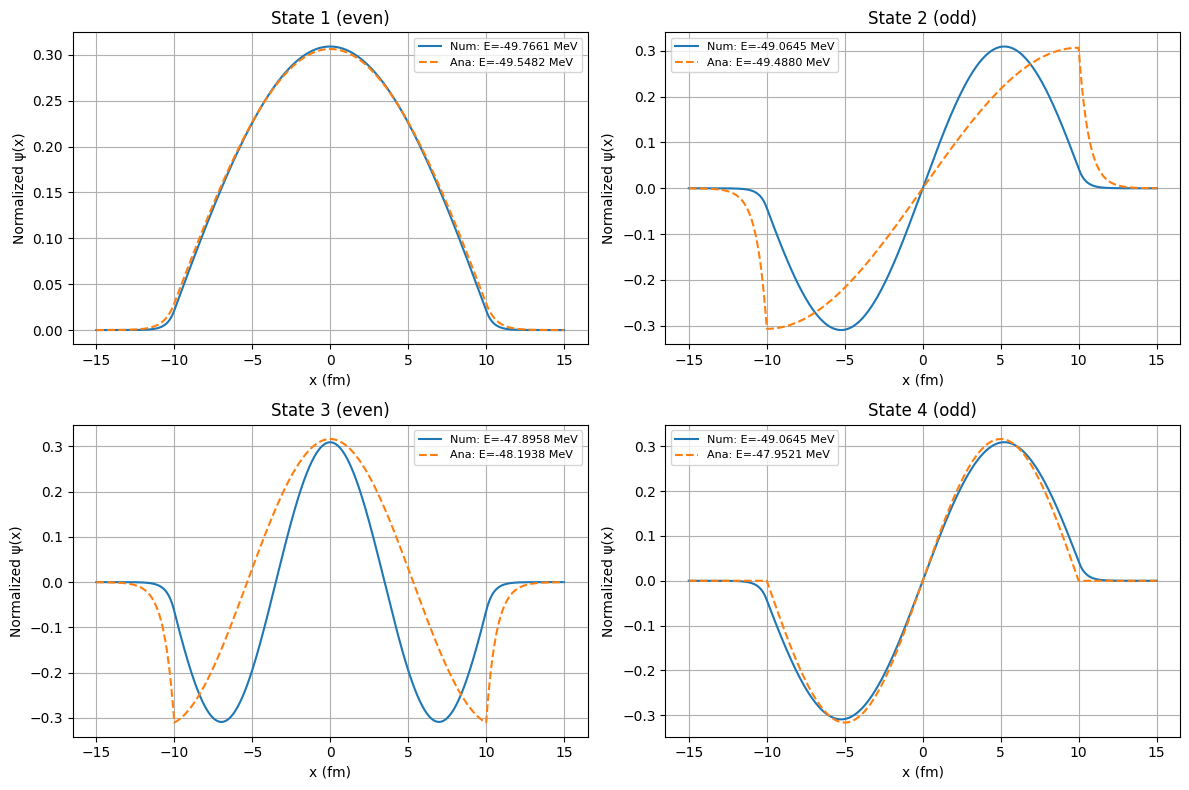

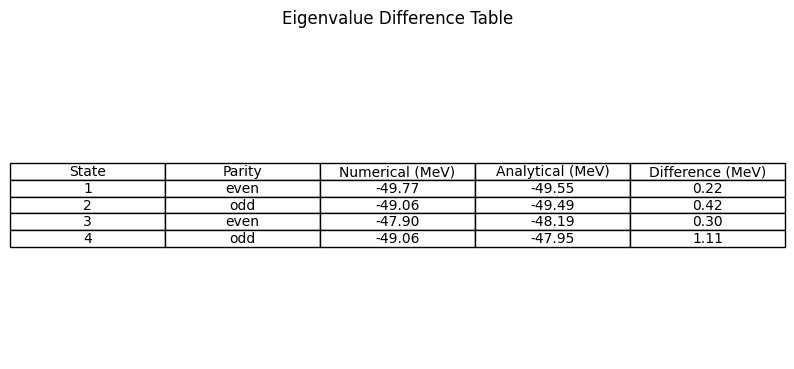

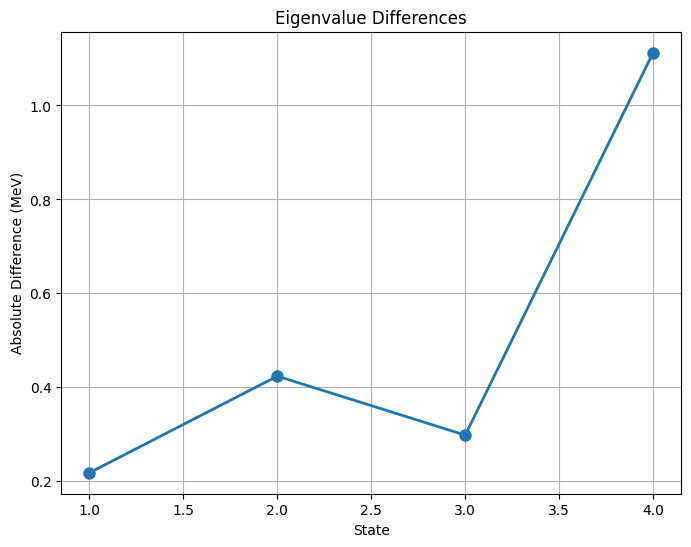

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Constants and parameters
hbar2_over_2m = 20.75   # MeV·fm²
a = 10.0                # fm, well extends from -a to +a
V0 = 50.0              # MeV, depth of the square well
tolerance = 1e-8        # Convergence criterion for energy
h = 0.01                # fm, step size for integration

# Number of states to compute
n_states = 4

# Finite square well potential
def V(x):
    return -V0 if abs(x) <= a else 0.0

# -------------------------------------------------------
# Analytical solution functions for the finite square well
# -------------------------------------------------------
def f_even(E):
    # Even parity condition: k tan(ka) = κ
    if E <= -V0 or E >= 0:
        return np.nan
    k = np.sqrt((E + V0) / hbar2_over_2m)
    kappa = np.sqrt(-E / hbar2_over_2m)
    return k * np.tan(k * a) - kappa

def f_odd(E):
    # Odd parity condition: k cot(ka) = -κ  (cot = 1/tan)
    if E <= -V0 or E >= 0:
        return np.nan
    k = np.sqrt((E + V0) / hbar2_over_2m)
    kappa = np.sqrt(-E / hbar2_over_2m)
    return k / np.tan(k * a) + kappa

def find_roots(func, E_min, E_max, num_points=10000):
    E_grid = np.linspace(E_min, E_max, num_points)
    f_vals = np.array([func(E) for E in E_grid])
    roots = []
    for i in range(len(E_grid) - 1):
        if np.isnan(f_vals[i]) or np.isnan(f_vals[i+1]):
            continue
        if f_vals[i] * f_vals[i+1] < 0:
            try:
                root = brentq(func, E_grid[i], E_grid[i+1])
                roots.append(root)
            except Exception:
                pass
    return roots

# Find all analytical eigenvalues in (-V0, 0)
even_roots = find_roots(f_even, -V0 + 1e-6, -1e-6)
odd_roots  = find_roots(f_odd,  -V0 + 1e-6, -1e-6)
analytical_eigenvalues_all = sorted(even_roots + odd_roots)

# Restrict to the first n_states eigenvalues.
analytical_eigenvalues = analytical_eigenvalues_all[:n_states]
analytical_states = []
for i, E in enumerate(analytical_eigenvalues):
    # Assumes ordering alternates: even, odd, even, odd, ...
    parity = 'even' if i % 2 == 0 else 'odd'
    analytical_states.append((E, parity))

def analytical_wavefunction(E, x, parity):
    k = np.sqrt((E + V0) / hbar2_over_2m)
    kappa = np.sqrt(-E / hbar2_over_2m)
    if parity == 'even':
        if abs(x) <= a:
            return np.cos(k * x)
        else:
            return np.cos(k * a) * np.exp(-kappa * (abs(x) - a))
    elif parity == 'odd':
        if abs(x) <= a:
            return np.sin(k * x)
        else:
            return np.sign(x) * np.sin(k * a) * np.exp(-kappa * (abs(x) - a))

# -------------------------------------------------------
# Improved symmetric shooting method (from x=0 outward)
# -------------------------------------------------------
def numerov_shoot(E, parity, x_grid):
    N = len(x_grid)
    psi = np.zeros(N)
    if parity == 'even':
        psi[0] = 1.0
        k0 = 2 * (E - V(0)) / hbar2_over_2m
        psi[1] = 1.0 - (h**2 / 2) * k0  # Taylor expansion: ψ(h) ≈ ψ(0) + (h²/2)ψ''(0)
    elif parity == 'odd':
        psi[0] = 0.0
        psi[1] = h  # since ψ'(0)=1 (arbitrary scaling)
    else:
        raise ValueError("Parity must be 'even' or 'odd'")
    # Pre-calculate k(x)
    k_array = np.array([2 * (E - V(x)) / hbar2_over_2m for x in x_grid])
    for i in range(1, N - 1):
        psi[i+1] = ((2 * (1 - (5 * h**2 / 12) * k_array[i]) * psi[i]
                     - (1 + (h**2 / 12) * k_array[i-1]) * psi[i-1])
                    / (1 + (h**2 / 12) * k_array[i+1]))
    return psi

def f_boundary(E, parity, x_grid):
    psi = numerov_shoot(E, parity, x_grid)
    return psi[-1]  # We require ψ(x_max) ≈ 0

def get_numerical_eigenvalue(parity, E_guess, x_grid, delta=0.5):
    E_low = E_guess - delta
    E_high = E_guess + delta
    f_low = f_boundary(E_low, parity, x_grid)
    f_high = f_boundary(E_high, parity, x_grid)
    # Expand the bracket if needed
    while f_low * f_high > 0:
        delta *= 1.5
        E_low = E_guess - delta
        E_high = E_guess + delta
        f_low = f_boundary(E_low, parity, x_grid)
        f_high = f_boundary(E_high, parity, x_grid)
    eigenvalue = brentq(lambda E: f_boundary(E, parity, x_grid), E_low, E_high, xtol=tolerance)
    return eigenvalue

# Use a larger x_max to capture the long tail of the higher states
x_max = 15.0  # fm
x_grid_shoot = np.arange(0, x_max + h, h)

# Compute numerical eigenvalues and full (symmetric) wavefunctions for the n_states.
numerical_states = []
numerical_eigenvalues = []
for E_analytical, parity in analytical_states:
    E_num = get_numerical_eigenvalue(parity, E_analytical, x_grid_shoot, delta=0.5)
    numerical_eigenvalues.append(E_num)
    psi_half = numerov_shoot(E_num, parity, x_grid_shoot)
    # Reflect to get full wavefunction on [-x_max, x_max]
    if parity == 'even':
        x_full = -x_grid_shoot[::-1][:-1]  # omit duplicate at 0
        psi_full = psi_half[::-1][:-1]
        x_full = np.concatenate((x_full, x_grid_shoot))
        psi_full = np.concatenate((psi_full, psi_half))
    elif parity == 'odd':
        x_full = -x_grid_shoot[::-1][:-1]
        psi_full = -psi_half[::-1][:-1]
        x_full = np.concatenate((x_full, x_grid_shoot))
        psi_full = np.concatenate((psi_full, psi_half))
    # Normalize the full wavefunction
    norm = np.sqrt(np.trapz(psi_full**2, x_full))
    psi_full /= norm
    numerical_states.append((E_num, parity, x_full, psi_full))

# Compute analytical wavefunctions on a full symmetric grid
x_full_ana = np.linspace(-x_max, x_max, 5000)
analytical_states_full = []
for E, parity in analytical_states:
    psi_analytical = np.array([analytical_wavefunction(E, x, parity) for x in x_full_ana])
    norm = np.sqrt(np.trapz(psi_analytical**2, x_full_ana))
    psi_analytical /= norm
    analytical_states_full.append((E, parity, x_full_ana, psi_analytical))

# -------------------------------------------------------
# Plotting: Comparison of eigenfunctions (numerical vs analytical)
# -------------------------------------------------------
num_states = len(numerical_states)
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.subplot(2, int(np.ceil(num_states/2)), i + 1)
    E_num, parity, x_num, psi_num = numerical_states[i]
    E_ana, _, x_ana, psi_ana = analytical_states_full[i]
    plt.plot(x_num, psi_num, label=f'Num: E={E_num:.4f} MeV')
    plt.plot(x_ana, psi_ana, '--', label=f'Ana: E={E_ana:.4f} MeV')
    plt.title(f"State {i+1} ({parity})")
    plt.xlabel("x (fm)")
    plt.ylabel("Normalized ψ(x)")
    plt.legend(fontsize=8)
    plt.grid()
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Prepare and plot difference table for eigenvalues
# -------------------------------------------------------
# Compute absolute differences and format table data.
table_data = []
abs_differences = []
for i in range(len(analytical_eigenvalues)):
    parity = 'even' if i % 2 == 0 else 'odd'
    num_val = numerical_eigenvalues[i]
    ana_val = analytical_eigenvalues[i]
    diff = abs(num_val - ana_val)
    abs_differences.append(diff)
    table_data.append([f"{i+1}", parity, f"{num_val:.2f}", f"{ana_val:.2f}", f"{diff:.2f}"])

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_data,
                 colLabels=["State", "Parity", "Numerical (MeV)", "Analytical (MeV)", "Difference (MeV)"],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Eigenvalue Difference Table", pad=20)
plt.show()

# -------------------------------------------------------
# Plotting: Difference trend
# -------------------------------------------------------
state_indices = np.arange(1, len(abs_differences) + 1)
plt.figure(figsize=(8, 6))
plt.plot(state_indices, abs_differences, 'o-', linewidth=2, markersize=8)
plt.xlabel("State")
plt.ylabel("Absolute Difference (MeV)")
plt.title("Eigenvalue Differences")
plt.grid(True)
plt.show()
